# Data science project, Regina & Adir - Flight prices prediction


## in this project, we tried to show how to choose the cheapest flight ticket from Tel Aviv

### For this goal we tested a few parameters the could influence the ticket price,such as - Airline company, Destination, Date, departure time, connection and class.

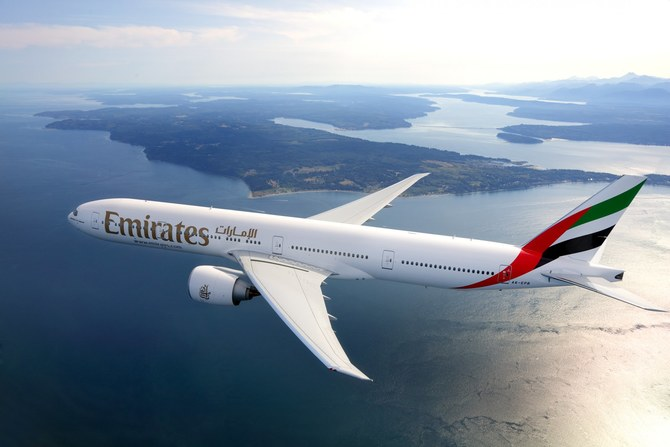

### First of all, we started with importing the modules nad packeges

In [1]:


#imports 
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import ActionChains
from tqdm import tqdm
import time
import string
from matplotlib import pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import geopy
import plotly.express as px
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import linear_model
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline
plt.rcParams.update({'figure.figsize':(40,10), 'figure.dpi':100})
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
from sklearn import svm



## Carwling with Selenium

## We decided to use selenium to do the crawling process for the following reason:
  1) To handle scrapping a dynamic website  <br> 
2) To handle pop up windows and ads  <br> 
3) Each destination has its own link, in order to get the info we had to enter each link, with selenium gave us more options to do this in efficient way


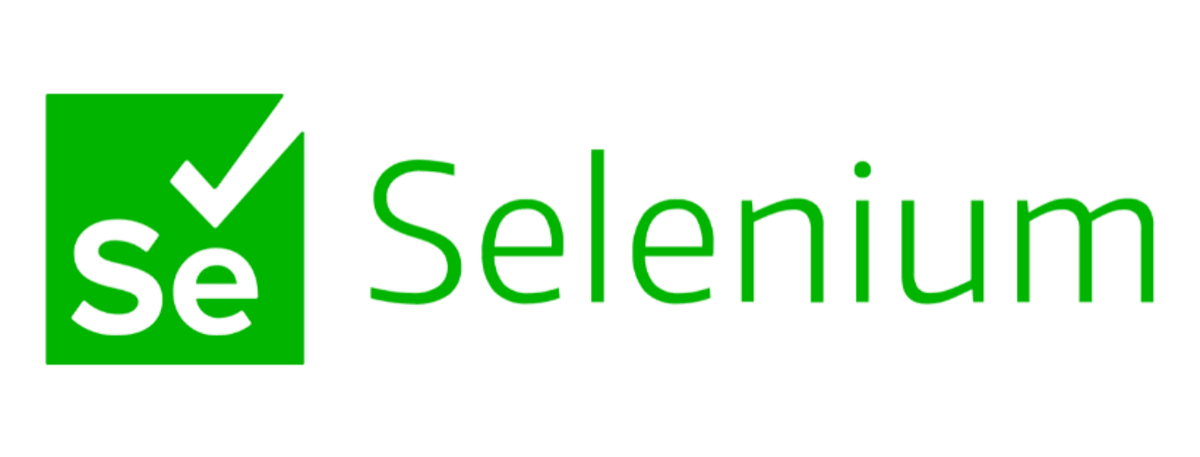

## in the cell below we load the browser driver for Selenium and then enter the webpage via the website link
We had to download the right driver for out webroser version and to copy its path into the fuction, after that, we executed the command "Wait" to selenium, in order to wait until the web is fully loaded before startng the to scrap the data<br>
If Selenium tries to get a particular data before it's loaded, we would get and error that the data is not found.<br>
So, in order to prevent this from happening, we waited after loading each link for 5 to 10 seconds before starting to automate the browser, this action costs us  some time but prevent a lot of errors.


In [2]:
#loading the website via the selenium scrapper

DRIVER_PATH = 'C:\Program Files (x86)\chromedriver.exe'

driver = webdriver.Chrome(executable_path = DRIVER_PATH)
driver.implicitly_wait(10)

driver.get('https://www.kiwi.com/en/search/tiles/--/--/2022-06-23_2023-07-22/no-return')

C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/2491805127.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path = DRIVER_PATH)


### handling cookies pop ups
When first loading the destination webpage, a cookie alert pops up, so in order to get the web we had to automatically handle it with selenium, so we copied the Xpath of the "X" button of the pop up widow, and use the function "click" to click it and move on to the actual web page.

In [3]:
#pressing the "load more" button multiple times to get more results
time.sleep(10)

driver.find_element_by_xpath('//*[@id="cookie_consent"]/div/div/div/section/div[2]/button').click()

time.sleep(10)
driver.find_element_by_css_selector("button[class='ButtonPrimitive__StyledButtonPrimitive-sc-1lbd19y-0 Ixryp'] div[class='ButtonPrimitiveContentChildren__StyledButtonPrimitiveContentChildren-sc-1m4y8u8-0 cDZXgY']").click()
i=0
while i<1:
    try:
        NextStory = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[class='ButtonPrimitive__StyledButtonPrimitive-sc-1lbd19y-0 Ixryp'] div[class='ButtonPrimitiveContentChildren__StyledButtonPrimitiveContentChildren-sc-1m4y8u8-0 cDZXgY")))
        NextStory.click()
    except:
        i=1


C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/2013534980.py:4: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  driver.find_element_by_xpath('//*[@id="cookie_consent"]/div/div/div/section/div[2]/button').click()
C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/2013534980.py:7: DeprecationWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead
  driver.find_element_by_css_selector("button[class='ButtonPrimitive__StyledButtonPrimitive-sc-1lbd19y-0 Ixryp'] div[class='ButtonPrimitiveContentChildren__StyledButtonPrimitiveContentChildren-sc-1m4y8u8-0 cDZXgY']").click()


## Here we are clicking "show more" button to load all of the destinations and then extracting the links for each destination
in order to get as much info as we can, we had to click the "show more" button at the buttom of the page, we used Selenium click function to do so, until it's no longer appear, after we loaded all of the destination we could move on to scrap the links of each destination.

In [4]:
#extracting the links of each destination flights
#in order to enter each link and extract all of the flight to that destination

time.sleep(8)
destinations_links = []
flights_categories = driver.find_elements_by_class_name("PictureCardstyled__StyledPictureCard-sc-1i137c0-0.dnbSjQ")

dest_num = len(flights_categories)

for flight in range(dest_num):
    destinations_links.append(flights_categories[flight].get_attribute('href'))

destinations_links

C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/3579848666.py:6: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  flights_categories = driver.find_elements_by_class_name("PictureCardstyled__StyledPictureCard-sc-1i137c0-0.dnbSjQ")


['https://www.kiwi.com/en/search/results/tel-aviv-israel/orlando-florida-united-states/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/istanbul-turkey/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/las-vegas-nevada-united-states/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/barcelona-spain/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/manila-philippines/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/london-united-kingdom/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/malaga-spain/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/madrid-spain/2022-06-30_2023-07-22/no-return',
 'https://www.kiwi.com/en/search/results/tel-aviv-israel/singapore-singapore/2022-06-30_2023-07-22/no-return',
 

### Extracing the data of each flight to a list in order to turn it to a pandas dataframe

### we created empty lists to contain the data, each list will be a column in the pandas dataframe
we are iterating in a loop for each link(destination) and then inserting the right data to its list, for exapmple, we inserted all of the prices in Paris link with the funcion "get elements" by selenium and then after appending the prices list, we moved to the next destination in the loop. <br> 
we used in temp lists to hold the new data in the rigth link and eventually appeded the final list by looping the temp list and using the append option<br>
in the first link ([0]), there is always a pop up so we had to run the first one separatly outside the loop to hanld the pop up in the intial scape, and after that we could go into the loop as shwon below:

In [5]:

    #Extracting the flight data(price, date, destination, connection) in order to save it to the dataframe
    #scrolling with selenium and wait in order to load and get all of the prices
    #looping through each link to get all of the prices to all of the destinations
    prices = []
    priceslist = []
    datetime = []
    destination = []
    airline = []
    duration = []
    departure_time = []
    
    deslinknum = len(destinations_links)
    driver = webdriver.Chrome(executable_path = DRIVER_PATH)
    driver.implicitly_wait(10)
    driver.get(destinations_links[0])
    time.sleep(7)
    driver.find_element_by_xpath('//*[@id="cookie_consent"]/div/div/div/section/div[2]/button').click()
    time.sleep(7)
    htmlelement = driver.find_element_by_tag_name('html')
    htmlelement.send_keys(Keys.END)
    time.sleep(5)
    element = driver.find_elements_by_xpath("//*[@data-test='ResultCardPrice']")
    datelink = driver.find_elements_by_xpath("//*[@class='ResultCardItinerarystyled__DepartureDate-sc-iwhyue-1 hMHcTD']")
    destinationlinks = driver.find_elements_by_xpath("//*[@class='ResultCardItineraryPlacestyled__StopPlace-sc-1ekdizc-0 hLGRBu']")
    airlinelink = driver.find_elements_by_xpath("//*[@class='CarrierLogo__StyledImage-sc-1fb3c06-0 gPUJex']")
    durationlink = driver.find_elements_by_xpath("//*[@class='BadgePrimitive__StyledBadgeContent-sc-1ibxlos-2 laUebC']")
    departurelink = driver.find_elements_by_xpath("//*[@class='ResultCardItineraryPlacestyled__SemiBold-sc-1ekdizc-2 hYtDCl']")
    prices = [i.text for i in element]
    datetime = [k.text for k in datelink]
    destination = [n.text for n in destinationlinks]
    airline = [a.get_attribute('alt') for a in airlinelink]
    duration = [d.text for d in durationlink]
    departure_time = [dp.text for dp in departurelink]
    
    
    
    for link in range(1,dest_num):
        driver.get(destinations_links[link])
        time.sleep(7)
        temp = []
        datetemp = []
        destinationtemp = []
        airlinetemp = []
        durationtemp  =  []
        departuretemp = []
        
        htmlelement = driver.find_element_by_tag_name('html')
        htmlelement.send_keys(Keys.END)
        time.sleep(8)
        elements = driver.find_elements_by_xpath("//*[@data-test='ResultCardPrice']")
        datelink = driver.find_elements_by_xpath("//*[@class='ResultCardItinerarystyled__DepartureDate-sc-iwhyue-1 hMHcTD']")
        destinationlinks = driver.find_elements_by_xpath("//*[@class='ResultCardItineraryPlacestyled__StopPlace-sc-1ekdizc-0 hLGRBu']")
        airlinelink = driver.find_elements_by_xpath("//*[@class='CarrierLogo__StyledImage-sc-1fb3c06-0 gPUJex']")
        durationlink = driver.find_elements_by_xpath("//*[@class='BadgePrimitive__StyledBadgeContent-sc-1ibxlos-2 laUebC']")
        departurelink = driver.find_elements_by_xpath("//*[@class='ResultCardItineraryPlacestyled__SemiBold-sc-1ekdizc-2 hYtDCl']")
        temp = [j.text for j in elements]
        datetemp = [k.text for k in datelink]
        destinationtemp = [n.text for n in destinationlinks]
        airlinetemp = [a.get_attribute('alt') for a in airlinelink]
        durationtemp = [d.text for d in durationlink]                                             
        departuretemp = [dp.text for dp in departurelink]                                             
        
        
        for t in temp:
            prices.append(t)
        
        for d in datetemp:
            datetime.append(d)
        
        for des in destinationtemp:
            destination.append(des)
        
        for air in airlinetemp:
            airline.append(air)
                                                     
        for dur in durationtemp:
            duration.append(dur)
        
        for dep in departuretemp:
            departure_time.append(dep)
            
        
        
    
    
        
   
        
    
    

C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/90381952.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path = DRIVER_PATH)
C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/90381952.py:17: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  driver.find_element_by_xpath('//*[@id="cookie_consent"]/div/div/div/section/div[2]/button').click()
C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/90381952.py:19: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  htmlelement = driver.find_element_by_tag_name('html')
C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/90381952.py:22: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  element = driver.find_elements_by_xpath("//*[@data-test='ResultCardPrice

## Converting each list to a pandas dataframe
We converted each link to a pandas dataframe with Pd.Dataframe function, and then we use pd.concat to merge them into one big dataframe

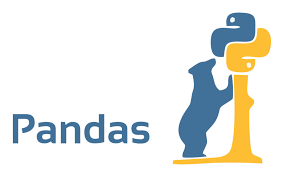

In [6]:
#converting the list to a pandas data frame and saving it as a csv file
desdf = pd.DataFrame(destination,columns = ['Destination'])

pricedf = pd.DataFrame(prices,columns = ['Price'])

datedf = pd.DataFrame(datetime, columns = ['Date'])

airlinedf = pd.DataFrame(airline, columns = ['Airline Company'])

xdf = pd.DataFrame(duration,columns = ['X'])

depdf = pd.DataFrame(departure_time,columns=['Departure Time'])



df = pd.concat([desdf,pricedf,datedf,airlinedf,xdf,depdf,], axis = 1)
df

,Destination,Price,Date,Airline Company,X,Departure Time
0,Tel Aviv,255 €\n1 seat left at this price,Wed 26 Oct,Wizz Air,24h 35m,22:00Tel Aviv
1,Orlando,255 €,Sun 23 Oct,Ryanair,,15:35\n+1\nOrlando
2,Tel Aviv,264 €\n1 seat left at this price,Wed 12 Oct,Norse Atlantic Airways,2 stops,21:35Tel Aviv
3,Orlando,264 €,Sun 16 Oct,Wizz Air,Travel hack,15:35\n+1\nOrlando
4,Tel Aviv,286 €\n1 seat left at this price,Sun 11 Sep,Ryanair,Economy,22:00Tel Aviv
...,...,...,...,...,...,...
13589,NaN,NaN,NaN,NaN,27h 20m,NaN
13590,NaN,NaN,NaN,NaN,,NaN
13591,NaN,NaN,NaN,NaN,2 stops,NaN
13592,NaN,NaN,NaN,NaN,Travel hack,NaN


In [7]:
df.to_csv('Flights.csv')

## we saved it to a CSV file, in order to use it each time we want instead of scrap with Selenium 
in order to prevent running with selenium each time we wanted the flight data, we just save the initial dataframe into a csv file and from there we just coule load it with pd.read_csv function to start handling the date before the machine learning process

In [8]:
data = pd.read_csv('Flights.csv')

data

,Unnamed: 0,Destination,Price,Date,Airline Company,X,Departure Time
0,0,Tel Aviv,255 €\n1 seat left at this price,Wed 26 Oct,Wizz Air,24h 35m,22:00Tel Aviv
1,1,Orlando,255 €,Sun 23 Oct,Ryanair,NaN,15:35\n+1\nOrlando
2,2,Tel Aviv,264 €\n1 seat left at this price,Wed 12 Oct,Norse Atlantic Airways,2 stops,21:35Tel Aviv
3,3,Orlando,264 €,Sun 16 Oct,Wizz Air,Travel hack,15:35\n+1\nOrlando
4,4,Tel Aviv,286 €\n1 seat left at this price,Sun 11 Sep,Ryanair,Economy,22:00Tel Aviv
...,...,...,...,...,...,...,...
13589,13589,NaN,NaN,NaN,NaN,27h 20m,NaN
13590,13590,NaN,NaN,NaN,NaN,NaN,NaN
13591,13591,NaN,NaN,NaN,NaN,2 stops,NaN
13592,13592,NaN,NaN,NaN,NaN,Travel hack,NaN


In [9]:
connectiondf = []
for x in data['X']:
    if x =='1 stop' or x == '2 stops' or x == '3 stops' or x == 'Direct' or x =='2 stops • Change airport':
        connectiondf.append(x)

condf = pd.DataFrame(connectiondf, columns =['Connection'])


economy = []

for ec in data['X']:
    if x =='Economy':
        economy.append(x)

ecodf = pd.DataFrame(economy, columns=['Class'])

flight_data = data.drop(['X','Unnamed: 0'],axis = 1, inplace = False )
flight_data = pd.concat([flight_data,condf], axis = 1)
flight_data = pd.concat([flight_data,ecodf], axis = 1)


  


# EDA and Data cleaning

We got a lot of NaN values and one column contaned 4 parameters. we called it X and then divide it to 4 columns and deleting the rows with the Nan values

In [10]:
flight_data['Departure Time'] = flight_data['Departure Time'].str.replace(r'\D', '')
flight_data['Price'] = flight_data['Price'].str.replace(r'\D', '')
flight_data

C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/3023703257.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  flight_data['Departure Time'] = flight_data['Departure Time'].str.replace(r'\D', '')
C:\Users\adirs\AppData\Local\Temp/ipykernel_157208/3023703257.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  flight_data['Price'] = flight_data['Price'].str.replace(r'\D', '')


,Destination,Price,Date,Airline Company,Departure Time,Connection,Class
0,Tel Aviv,2551,Wed 26 Oct,Wizz Air,2200,2 stops,Economy
1,Orlando,255,Sun 23 Oct,Ryanair,15351,2 stops,Economy
2,Tel Aviv,2641,Wed 12 Oct,Norse Atlantic Airways,2135,2 stops,Economy
3,Orlando,264,Sun 16 Oct,Wizz Air,15351,2 stops,Economy
4,Tel Aviv,2861,Sun 11 Sep,Ryanair,2200,2 stops,Economy
...,...,...,...,...,...,...,...
13589,NaN,NaN,NaN,NaN,NaN,NaN,Economy
13590,NaN,NaN,NaN,NaN,NaN,NaN,Economy
13591,NaN,NaN,NaN,NaN,NaN,NaN,Economy
13592,NaN,NaN,NaN,NaN,NaN,NaN,Economy


In [11]:
flight_data.rename(columns={"Price":"Price(€)"}, inplace = True)





In [12]:
flight_data.to_csv('Flights.csv')
flight_data


,Destination,Price(€),Date,Airline Company,Departure Time,Connection,Class
0,Tel Aviv,2551,Wed 26 Oct,Wizz Air,2200,2 stops,Economy
1,Orlando,255,Sun 23 Oct,Ryanair,15351,2 stops,Economy
2,Tel Aviv,2641,Wed 12 Oct,Norse Atlantic Airways,2135,2 stops,Economy
3,Orlando,264,Sun 16 Oct,Wizz Air,15351,2 stops,Economy
4,Tel Aviv,2861,Sun 11 Sep,Ryanair,2200,2 stops,Economy
...,...,...,...,...,...,...,...
13589,NaN,NaN,NaN,NaN,NaN,NaN,Economy
13590,NaN,NaN,NaN,NaN,NaN,NaN,Economy
13591,NaN,NaN,NaN,NaN,NaN,NaN,Economy
13592,NaN,NaN,NaN,NaN,NaN,NaN,Economy


In some of the rows we got "Tel Aviv" in the destination, since we are tying to seach flight prices from tel aviv, we had to delete the rows the conained "Tel Aviv" in the destination, we use str contains to drop the rows

In [13]:
#EDA Data cleaning  - dropping rows with NaN

cleandata = flight_data.dropna(axis = 0, inplace = False)
cleandata = cleandata[cleandata["Destination"].str.contains("Tel Aviv") == False]

cleandata


,Destination,Price(€),Date,Airline Company,Departure Time,Connection,Class
1,Orlando,255,Sun 23 Oct,Ryanair,15351,2 stops,Economy
3,Orlando,264,Sun 16 Oct,Wizz Air,15351,2 stops,Economy
5,Orlando,286,Fri 26 Aug,Norse Atlantic Airways,15351,3 stops,Economy
7,Orlando,291,Sun 23 Oct,Ryanair,15351,3 stops,Economy
9,Orlando,291,Fri 9 Sep,Wizz Air,15351,3 stops,Economy
...,...,...,...,...,...,...,...
2505,Santorini,65,Mon 16 Jan,Cebu Pacific,2125,2 stops • Change airport,Economy
2507,Santorini,68,Sun 7 May,Cebu Pacific,2125,2 stops,Economy
2509,Santorini,68,Thu 9 Feb,Cebu Pacific,2125,3 stops,Economy
2511,Santorini,78,Sat 4 Mar,Ryanair,2125,2 stops,Economy


## We orderd the rows by the Destination columns alphabaticlly - we used sort_values function from pandas

In [14]:
#EDA

cleandata.sort_values('Destination', inplace=True)
cleandata.reset_index(inplace=True)



In [15]:
cleandata['Price(€)'] = cleandata['Price(€)'].astype(int)


## Visuallisation

### This is a pie chart of the different destination
As you can see the destinations are devided equally so there's no priority to a any destination in our model
we tried to use as many destinations as we can to get and authentic model, if we choose only destination in europe or USA that would be only patrial result and we would not get the full picture

<AxesSubplot:ylabel='None'>

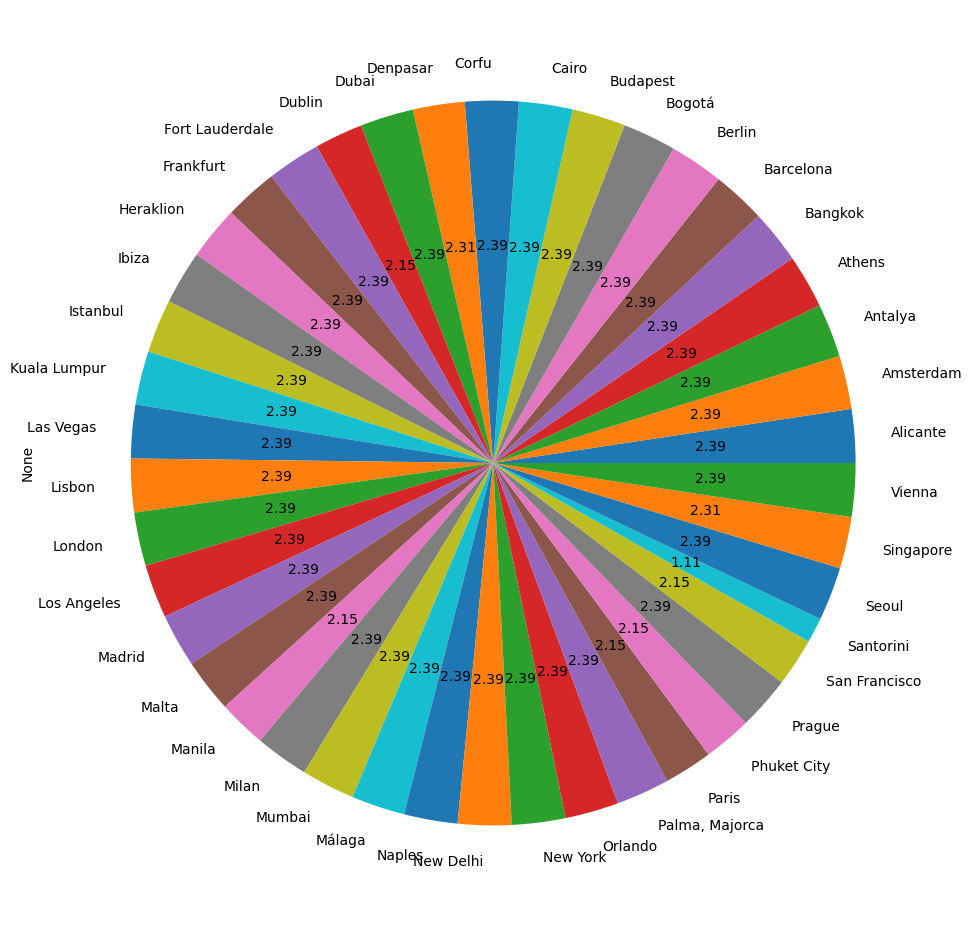

In [16]:
cleandata.groupby('Destination').size().plot(kind='pie', autopct='%.2f',figsize=(12, 12))


## Visuallisation - histogram:
Here we are showing the connection between destination and flight prices <br>
As you can see, the farther destination as Las vegas, Los angeles and Miami are the most expesive, but closer destinations as Viena, Malta, Berlin are cheaper.<br>
So with that information, we can think that there is a connection between distance and ticket prices.<br>
we decided to check that out in the machine learning model<br>


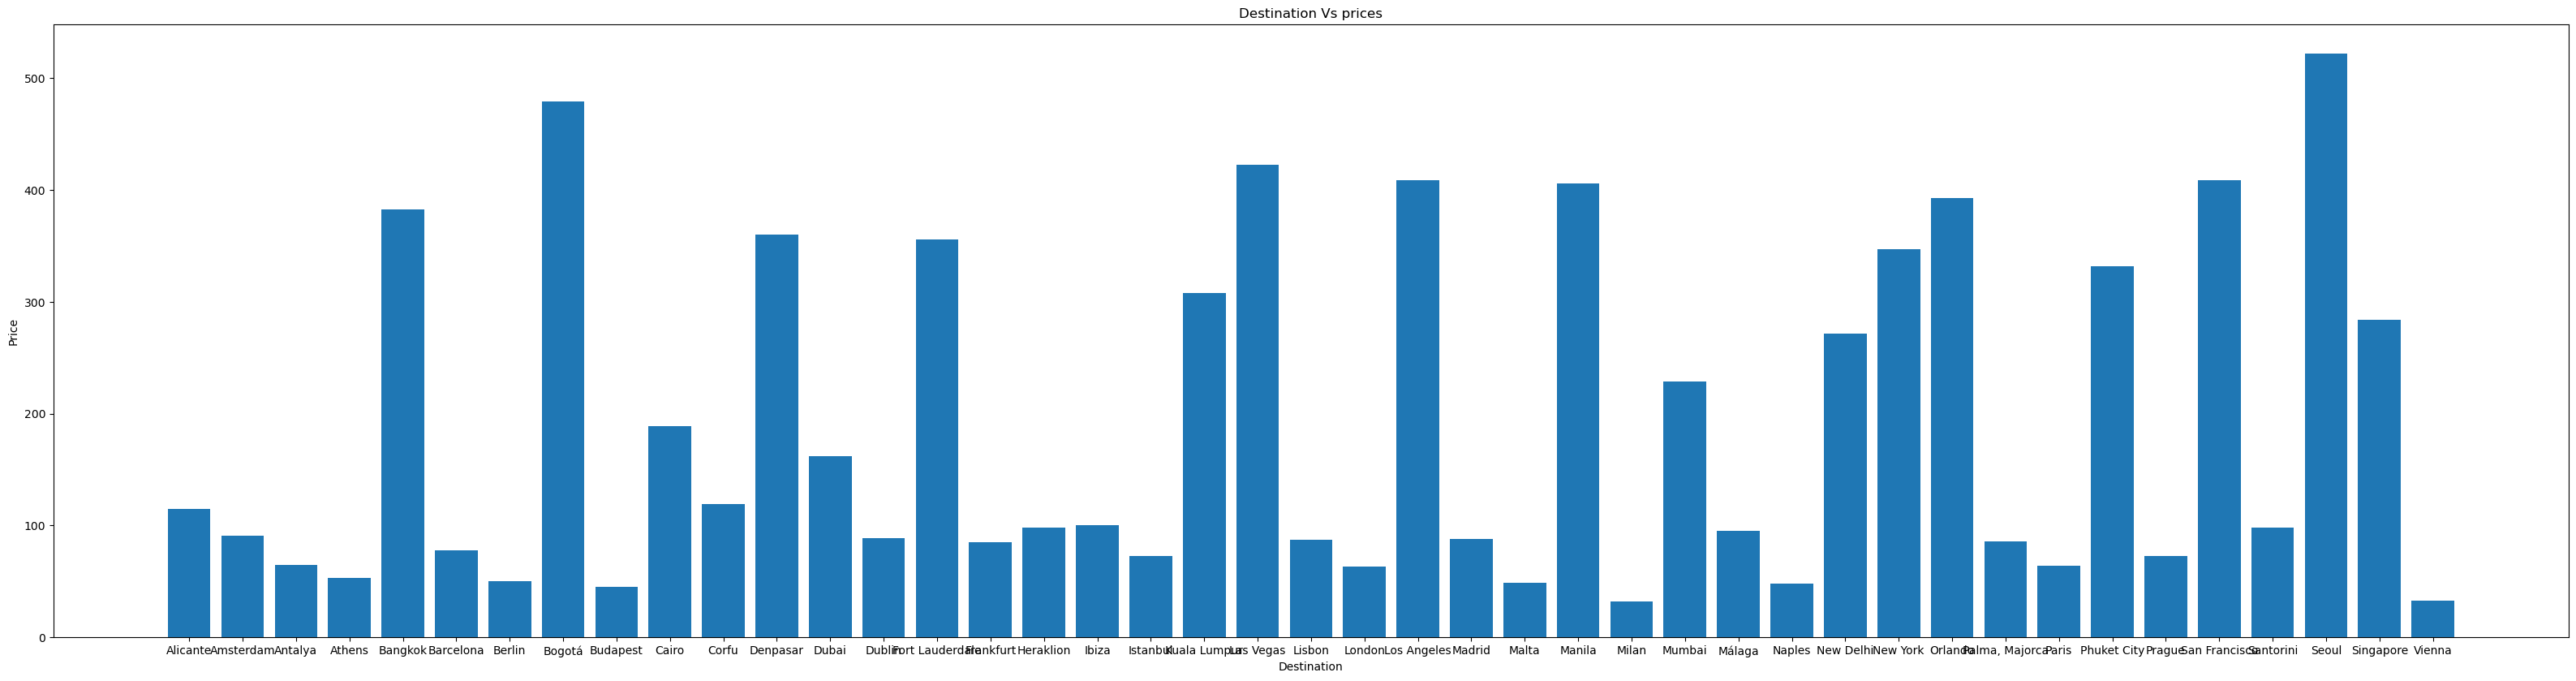

In [17]:
#bar plots of destination vs prices
x = cleandata['Destination']
y = cleandata['Price(€)']

plt.bar(x,y)
plt.xlabel('Destination')
plt.ylabel("Price")
plt.title('Destination Vs prices')
plt.show()

## Prices VS Connection:
In the graph we tested the connection between the price and the amount of stops<br>
as you can see, the direct flight is cheaper than the 2-stops flights, not as we expected<br>
we decided to investigate it more, maybe the connection parameter it not so significat as we thought it would be.<br>


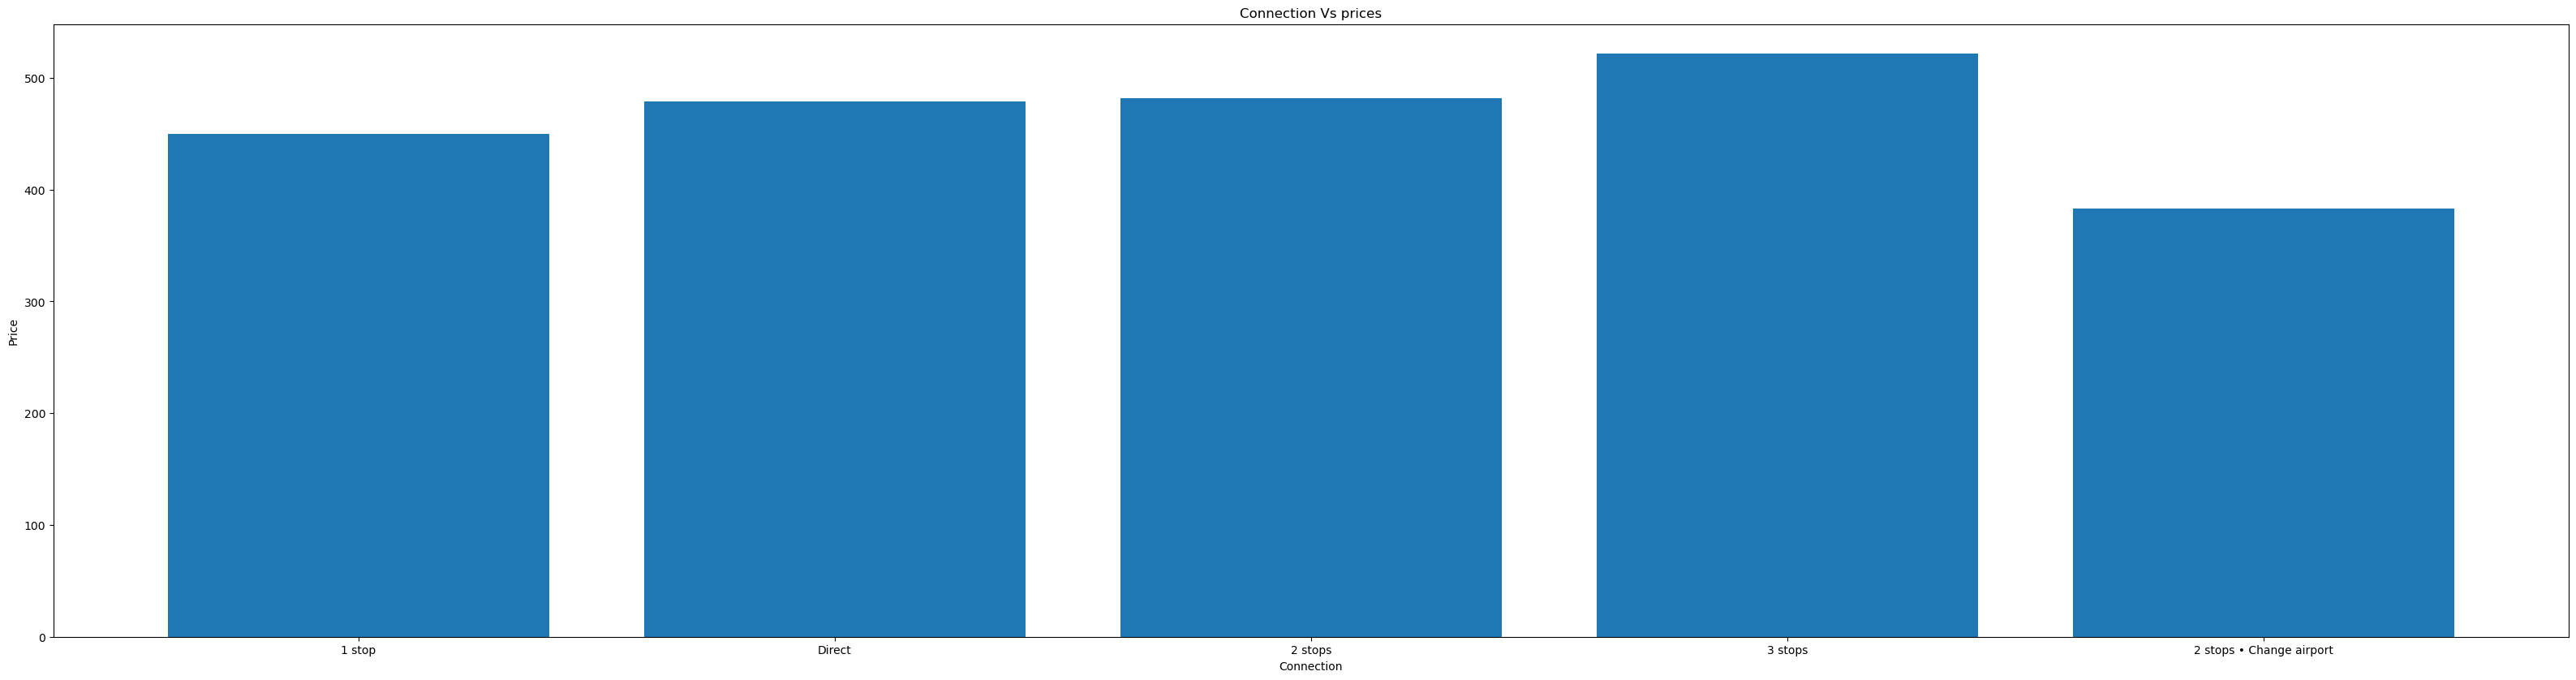

In [18]:
x = cleandata['Connection']
y = cleandata['Price(€)']

plt.bar(x,y)
plt.xlabel('Connection')
plt.ylabel("Price")
plt.title('Connection Vs prices')
plt.show()



## Prices VS Airline Company
We thought that the airline company is a significat parameter to the price as the destination, so we tried to visualise the connection between the airline company and the prices<br>
As you can see, the low-cost airlines are cheaper than the expensive one<br>
for expamle: see the "blue" prices VS EL-AL

C:\Users\adirs\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\adirs\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


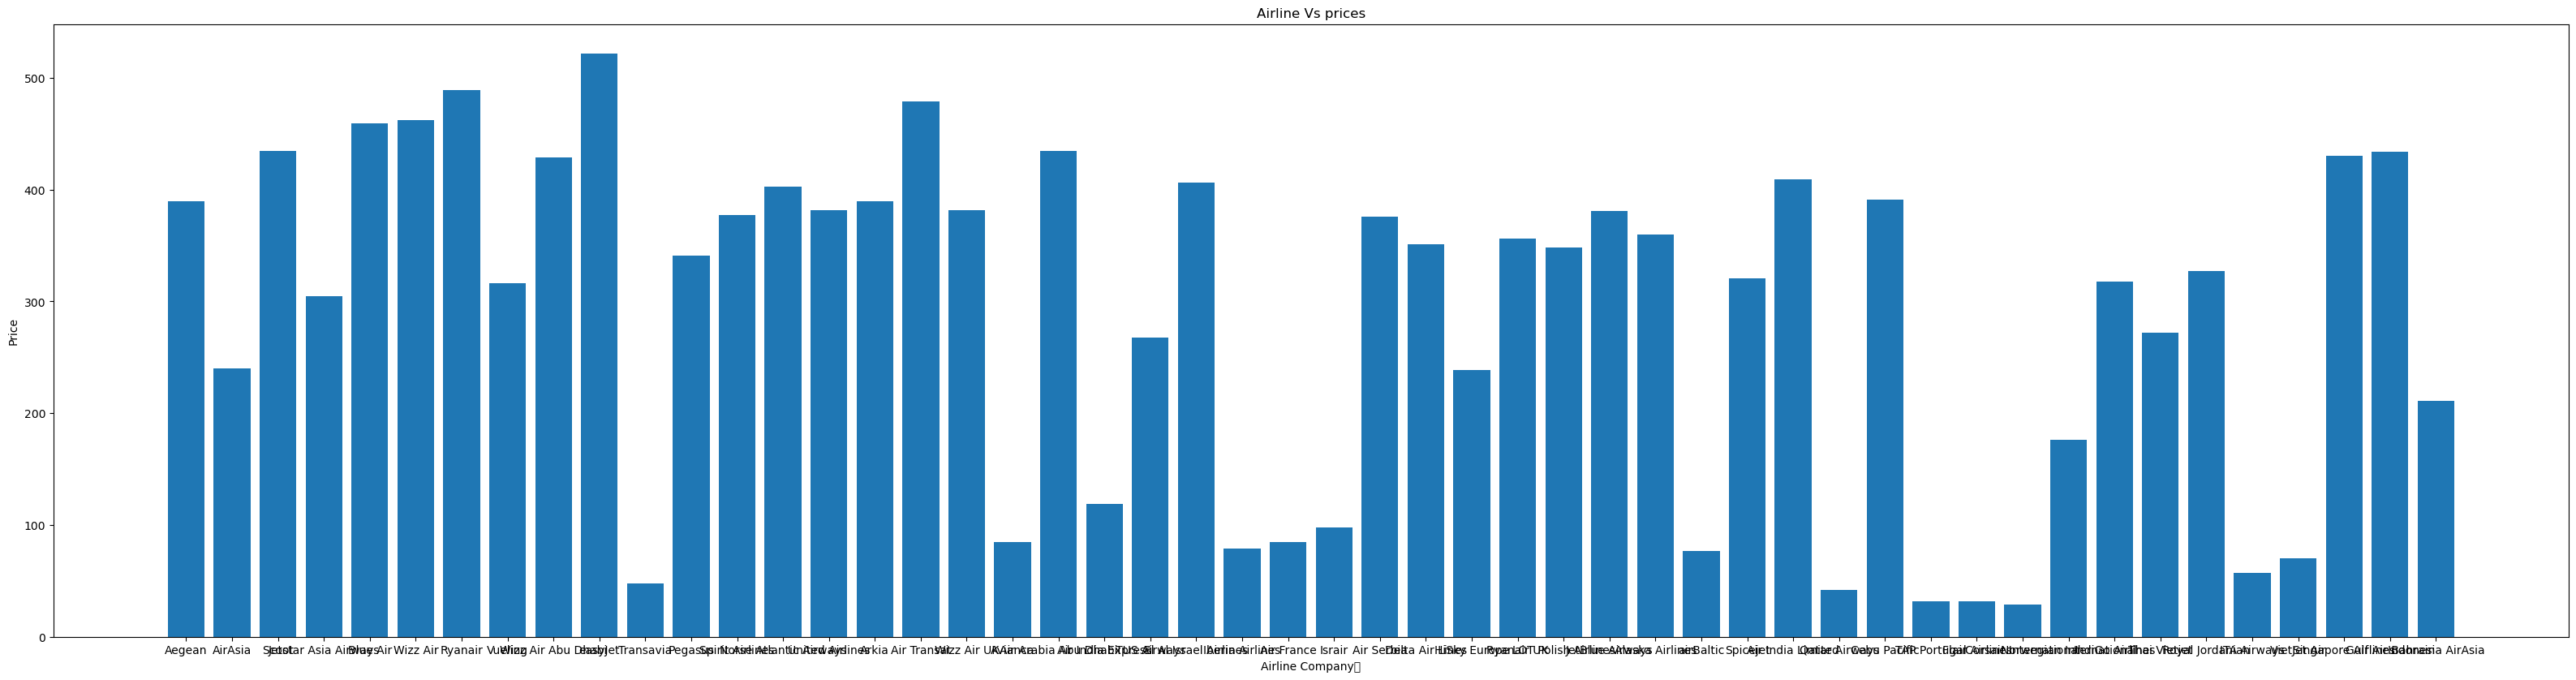

In [19]:
x = cleandata['Airline Company']
y = cleandata['Price(€)']

plt.bar(x,y)
plt.xlabel('Airline Company	')
plt.ylabel("Price")
plt.title('Airline Vs prices')
plt.show()

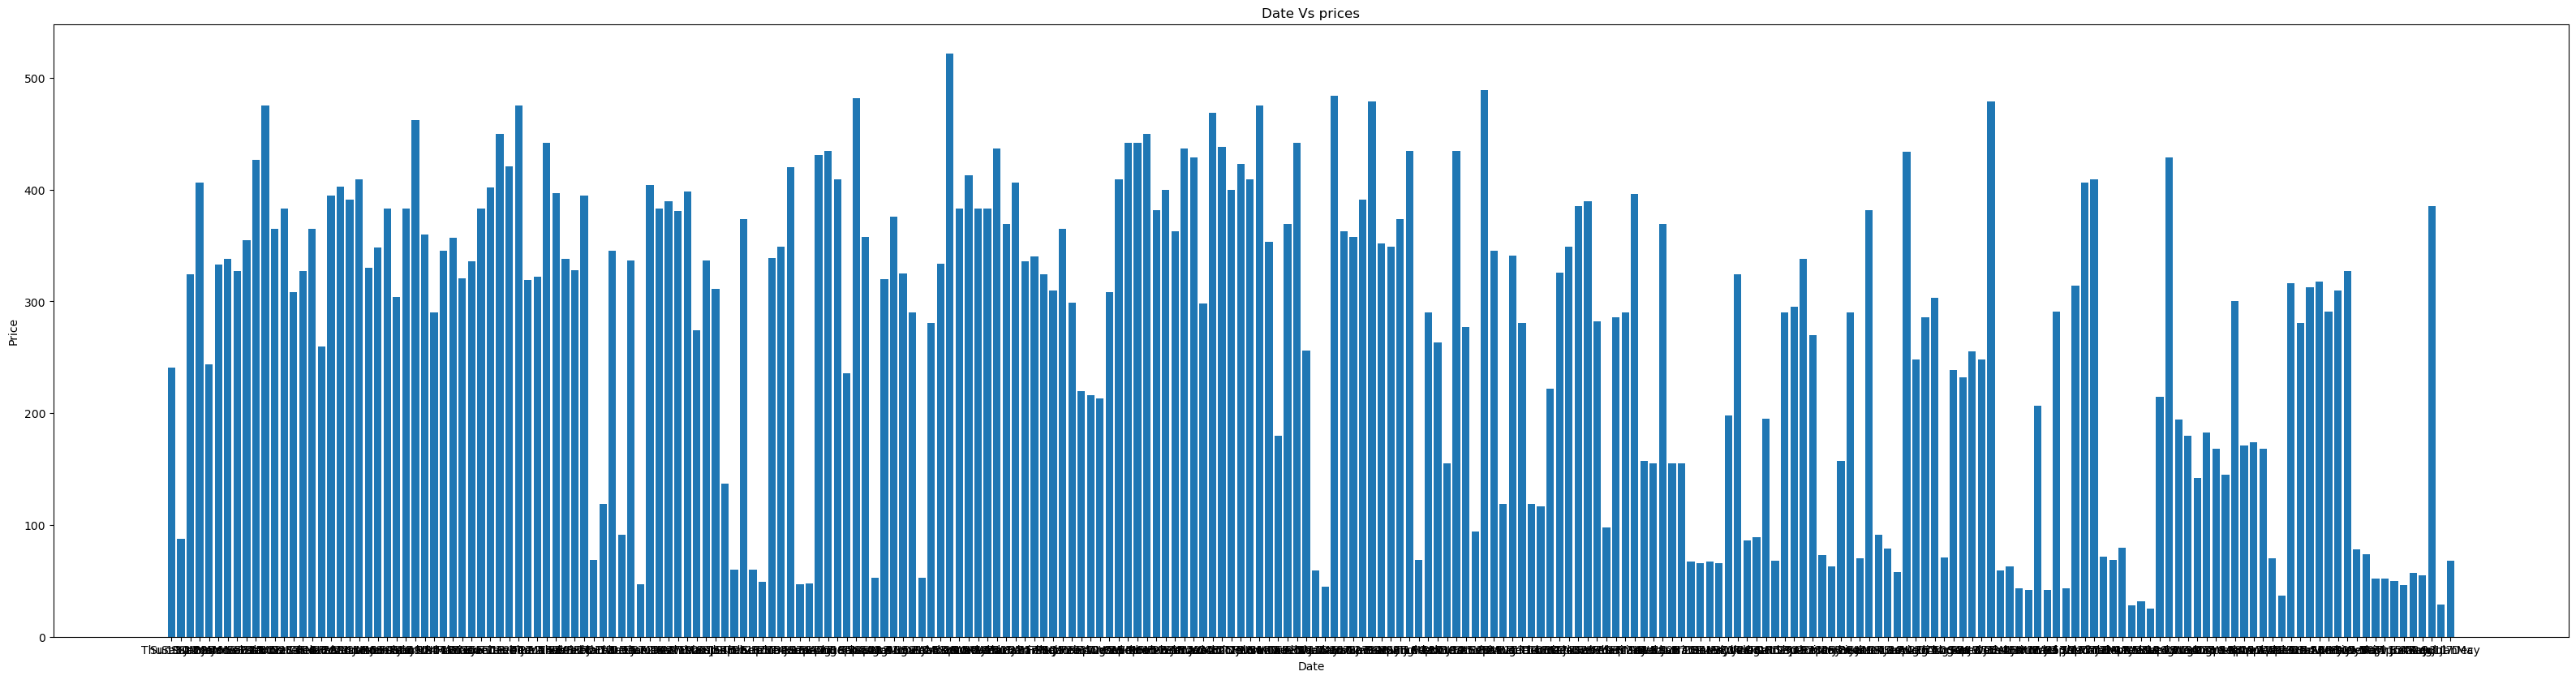

In [20]:
x = cleandata['Date']
y = cleandata['Price(€)']

plt.bar(x,y)
plt.xlabel('Date')
plt.ylabel("Price")
plt.title('Date Vs prices')
plt.show()

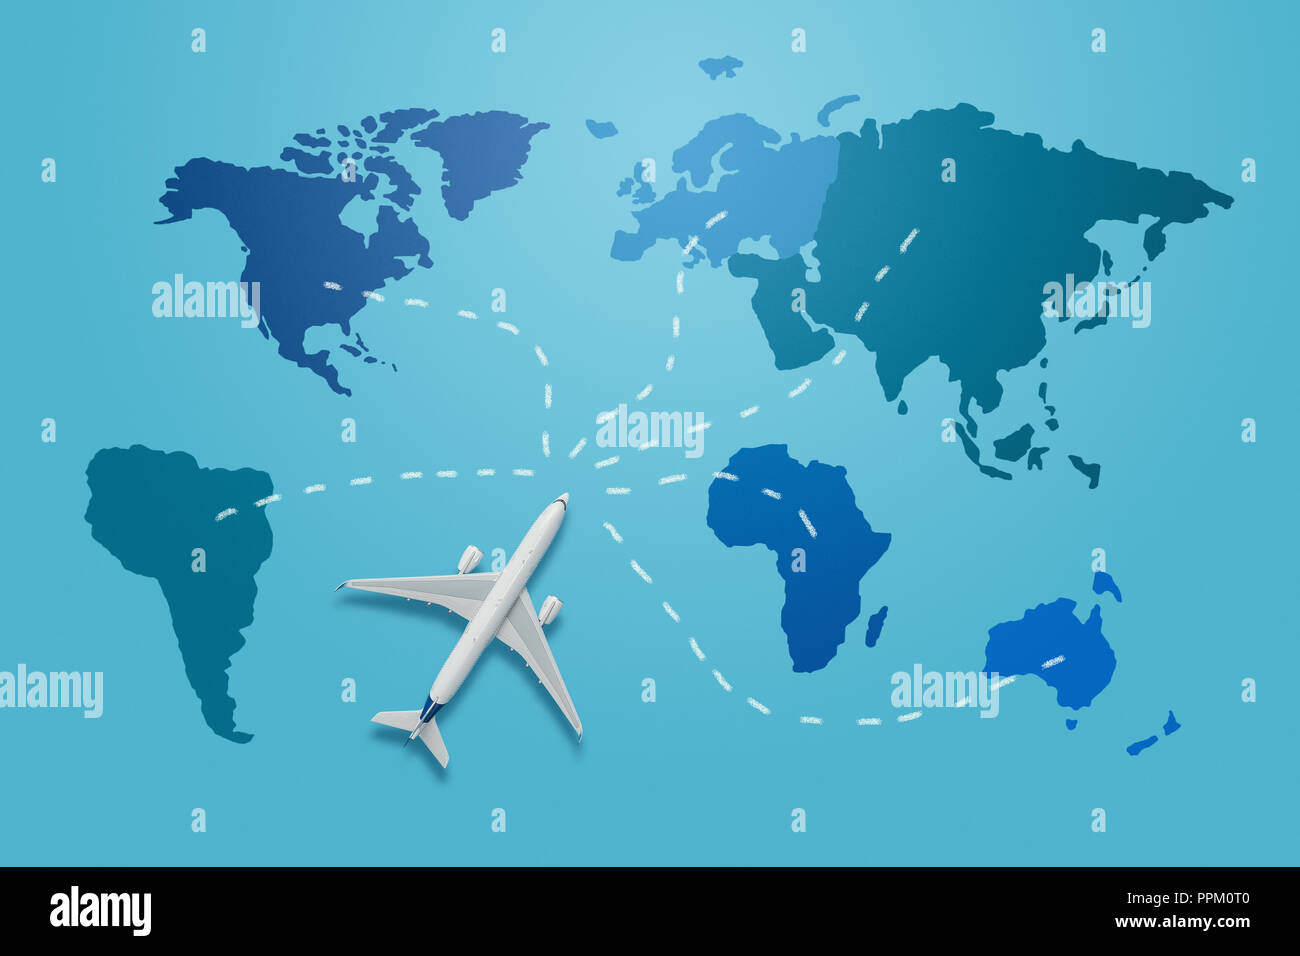

In [21]:
#converting to numeric data
mldf = cleandata.drop("Class",axis=1, inplace=False)
mldf.drop("Date",axis=1, inplace=True)
mldf.drop("Airline Company",axis=1, inplace=True)
mldf.drop("index",axis=1, inplace=True)




KeyError: "['level_0'] not found in axis"

## Preparing the data to machine learning
We choose to use the Linear regression algorithm - since we needed a supervied machine learning with numeric result(Price prediction)
So in order to use the Linear regression method, we had to conert the categorical values to numeric ones before inserting them to the Machine learning functions.
we used the following funtion:


In [22]:
mldf.Destination = pd.Categorical(mldf.Destination)
mldf['Destinations'] = mldf.Destination.cat.codes
mldf.drop("Destination",axis=1, inplace=True)




In [23]:
mldf.Connection = pd.Categorical(mldf.Connection)
mldf['Connection'] = mldf.Connection.cat.codes
mldf.drop("Connection",axis=1, inplace=True)
mldf

,Price(€),Departure Time,Destinations
0,71,1805,0
1,61,1840,0
2,63,2145,0
3,77,2105,0
4,59,2305,0
...,...,...,...
1252,21,1900,42
1253,21,2200,42
1254,21,2230,42
1255,22,2140,42


## Machine learning functions:
we used the foloowing fuctions to use the machine learning model:
split - to split the data into tran and test for the train and predict functions.<br>
Train model - to train the train data 
Predict - to predic the trained data
Evaluation performance - to evaluate the model on the test data and to see how acuurate was the prediction model

In [24]:
#machine learning

def train_model(X_train, y_train):
    ###
    ### YOUR CODE HERE
    ###
    trained_model = linear_model.LinearRegression()
    x = X_train[:]
    y = y_train
    trained_model.fit(X=x, y=y);
    
    return trained_model



def load_dataset(file_name, target_column):
    ###
    ### YOUR CODE HERE
    ###
    x = pd.read_csv(file_name)
    y = x[target_column]
    X = x.drop(target_column, axis = 1)
    
    
    
    return X, y

def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    ###
    ### YOUR CODE HERE
    ###
        ###
    ### YOUR CODE HERE
    TRAINING_FEATURES=dataset.columns[dataset.columns != label_column]
    TARGET_FEATURE=label_column
    
    X=dataset[TRAINING_FEATURES]
    y=dataset[TARGET_FEATURE]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rand_state)
    return X_train, X_test, y_train, y_test
    ###
    
def predict_1st(trained_1st_model, X_test):
    ###
    ### YOUR CODE HERE
    ###
    predicted_vals = trained_1st_model.predict(X_test)
    
    return predicted_vals

def evaluate_performance_1st(y_test,y_predicted):
    ###
    ### YOUR CODE HERE
    ###
    
    evaluate_value = r2_score(y_test,y_predicted)
    
    return evaluate_value


In [25]:
test_ratio, rand_state = 0.2, 42
category_col_name = 'Price(€)'
dataset = mldf
X_train, X_test, y_train, y_test = split_to_train_and_test(dataset, category_col_name, test_ratio, rand_state)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1005, 2) (252, 2) (1005,) (252,)


In [26]:
target_col_name = 'Price(€)'
X, y = load_dataset('Flights.csv', target_col_name)
print(X.shape,y.shape)



(13594, 7) (13594,)


In [27]:
#machine learning
trained_model_1st = train_model(X_train, y_train)



In [28]:
pred_1st_vals = predict_1st(trained_model_1st, X_test)


## Accuracy precentage:
At this stage we used the function evaluate performence to evaluate a acuuracy of out model<br>
After we got the pecentage of out model, we ran cross-validation method get a more acuurate picture.
 

In [29]:
y_pred_1st= pd.Series(pred_1st_vals,index=X_test.index)
eval_res_1st = evaluate_performance_1st(y_test, pred_1st_vals)
print(eval_res_1st)

0.5597558741554693


In [ ]:
#tying to improve via cross validation
clf = svm.SVC(kernel="linear", C=1, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=10)
scores




## Conclusion
in conclusion, as we expected the most significant parameter that influences the prices is the distance from the destination and the airline company.<br>
We assume the date should be a significant param as well, but we didn't see any strong correlation in the machine learning process.<br>
We thought that the numbers of stops should influence it too, but be saw that there was some cheaper flights in the direct flights than the ones with the connections.<br>
We decided to ignore the date parameter since the prices can vary depanding on how much time before the date the user purchase the flight. this variable made the prediciton very difficult and unstable.<br>

